In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

from scipy.stats import distributions

import pickle

# add utilities directory to path
import os, sys
util_path = os.path.abspath('utilities_and_data')
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import stan_utility
import stan_helper

import pystan

In [2]:
def get_stan_model(model_name, model_code, get_new=False):
    path = os.path.abspath(os.path.join(os.path.curdir, model_name))

    if not get_new and os.path.exists(path):
        print("Model exists already! Returning pickle.")
        return pickle.load(open(path, 'rb'))
    
    print("Path doesn't exist. Compiling model. It might take few minutes...")
    import pystan
    sm = pystan.StanModel(model_code=model_code)
    with open(model_name, 'wb') as f:
        pickle.dump(sm, f)
    return sm


In [3]:
with open("data/drowning.txt") as f:
    lines = f.read().splitlines()
    lines = [l.split() for l in lines]

years = np.array([int(l[0]) for l in lines])
victims = np.array([int(l[1]) for l in lines])
N = len(years)
xpred = 2016    # Predict for 2016

In [4]:
data =pd.DataFrame.from_items([('years',years), ('victims', victims)])
# sns.pairplot(data, x_vars=['years'], y_vars='victims', size=7, kind='reg')

In [5]:
# Gaussian linear model with uniform priors
drowning_code = """
data {
  int<lower=0> N; // number of data points
  vector[N] x; //
  vector[N] y; //
  real xpred; // input location for prediction
 }
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}
model {
  y ~ normal(mu, sigma);
}
generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(alpha + beta*xpred, sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
}
"""

In [6]:
data = dict(
    N = N,
    x = years,
    y = victims,
    xpred = xpred,
)

In [7]:
# sm = pystan.StanModel(model_code=drowning_code)
sm_drowning = get_stan_model('drowning_model.pkl', drowning_code)

Model exists already! Returning pickle.


## Question 1.1
What can you say about the trend in the number of people drown per year? Plot the histogram of the slope of the linear model.

In [8]:
fit = sm_drowning.sampling(data=data, iter=1000, chains=4); 

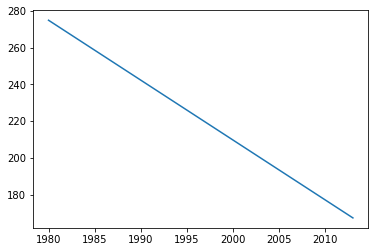

In [26]:
mu = [fit['mu'][:,i].mean() for i in range(34)]
years = [1980 + i for i in range(34)]
plt.plot(years, mu)

If you look at the data, the number of people drown per year is decreasing.

In [27]:
samples = fit.extract(permuted=True)

### Histogram of the slope of the linear model

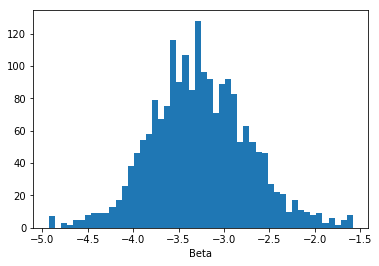

In [28]:
# Warmups are already discarded
plt.hist(samples['beta'], 50)
plt.xlabel("Beta")

### 2). What does the model predict for year 2016? Plot the histogram of the posterior predictive distribution for number of people drown at x = 2016.


For year 2016 the model predicts __156.95 people would die in average with standard error mean of 0.75__.

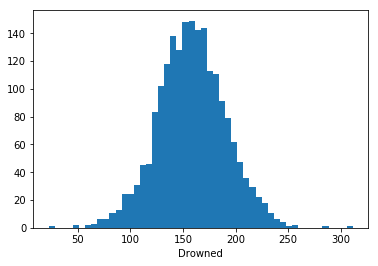

In [29]:
plt.hist(samples['ypred'], 50)
plt.xlabel("Drowned")

# 2. Hierarchical model: factory data with Stan (3p)

The provided factory.txt file contains quality control measurements from 6 machines in a factory (units of the measurements are irrelevant here). Quality control measurements are expensive and time-consuming, so only 5 measurements were done for each machine. In addition to the existing machines, we are interested in the quality of another machine (the seventh machine). 

Implement a 
- separate, 
- pooled and 
- hierarchical Gaussian model 
    
described in Section 11.6 using Stan. 

Similarly as in the model description in the book, __use the same measurement standard deviation σ for all the groups in the hierarchical model__. In the separate model however, __use separate measurement standard deviation $\sigma_j$ for each group j__. 

Using each of the three models – separate, pooled, and hierarchical – report (__plot histogram and comment on the results__):

### Reference
- http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/#The-Models

## Questions
- What is the random variable here?
    - How do we predict without rv?
    - What is predictive distribution?

Load model

In [30]:
d = np.loadtxt("data/factory.txt")

## (2-1). Separate model with unequal standard deviations

$$ y_{i,m} = \alpha_m + \beta_m \times \text{machine}_{i,m} + \epsilon_m $$

- $i$: measurement index
- $m$: machine being measured

$\epsilon$ is an error term sampled from $N(\mu, \sigma_\epsilon)$

Here we say that all six machines are completely different with no similarities. Based on this model we won't be able to predict another machine.

In [31]:
x = np.tile(np.arange(1, 7), d.shape[0])
y = d.ravel();y
N = len(x)
data = dict(
    N = N,
    K = 6,  # 6 machines
    x = x,  # group indicators
    y = y,   # observations
    target_machine = 5  # 6th machine
)

x.shape, y.shape

((30,), (30,))

In [32]:
#  Comparison of k groups with common variance (ANOVA)
data_code = '''
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
  int<lower=0> target_machine;
}
parameters {
  vector[K] mu;        // group means
  vector<lower=0>[K] sigma; // group stds
  //real<lower=0> sigma; // common std
}
model {
  //for (i in 1:N)
  //  y[i] ~ normal(mu[x[i]], sigma[x[i]]);
    y ~ normal(mu[x], sigma[x]);
}

generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(mu[target_machine], sigma[target_machine]);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[x[i]], sigma);
}
'''

In [33]:
# sm_separate = get_stan_model('factory_model.pkl', data_code, get_new=True)
sm_separate = get_stan_model('factory_model.pkl', data_code)

Model exists already! Returning pickle.


In [34]:
fit_separate = sm_separate.sampling(data=data, seed=194838);

In [35]:
# Extract samples in different forms for different parameters.
# permuted : bool
#    If True, returned samples are permuted. All chains are
#    merged and warmup samples are discarded.
samples_separate = fit_separate.extract(permuted=True)

stan_utility.check_treedepth(fit_separate)
stan_utility.check_energy(fit_separate)
stan_utility.check_div(fit_separate)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


`mu` is group mean. So get a column not row.

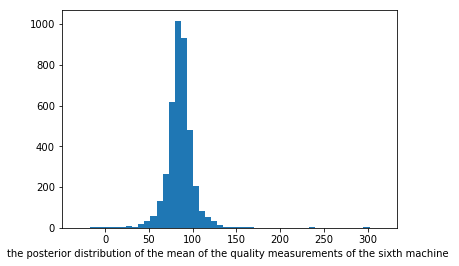

In [36]:
plt.hist(samples_separate['mu'][:,5], 50)
plt.xlabel("the posterior distribution of the mean of the quality measurements of the sixth machine ")

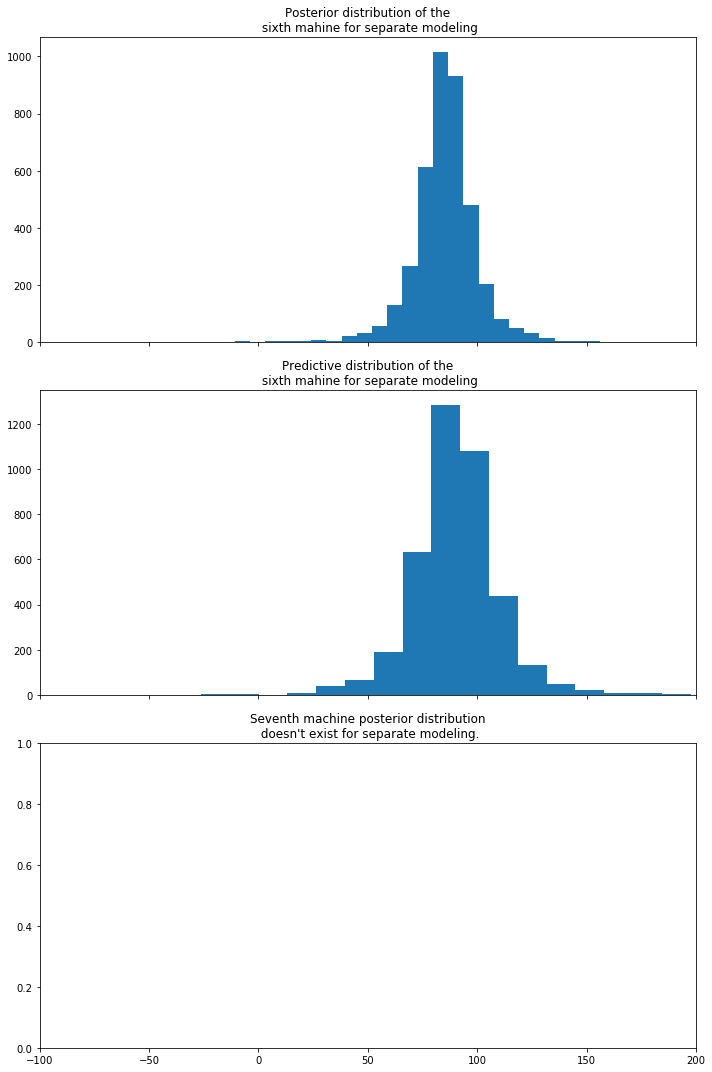

In [75]:
# create figure
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# plot the posterior density
ax = axes[0]
ax.set_xlim([-100,200])
ax.hist(samples_separate['mu'][:,5], 50)
ax.set_title('Posterior distribution of the\n sixth mahine for separate modeling')

ax = axes[1]
ax.hist(samples_separate['ypred'], 50)
ax.set_title("Predictive distribution of the\n sixth mahine for separate modeling")

ax = axes[2]
ax.set_title("Seventh machine posterior distribution\n doesn't exist for separate modeling.")


fig.tight_layout()

Posterior and predictive distributions look similar. For separate modeling, the seventh machine's posterior distribution doesn't exist, because separate modeling cannot infer a new machine as all six machines were supposed as completely different machies.

## (2-2). Pooled model

$$ y_{i,m} = \alpha + \beta \times \text{machine}_{i,m} + \epsilon_m $$

- $i$: measurement index
- $m$: machine being measured

$\epsilon$ is an error term sampled from $N(\mu, \sigma_\epsilon)$

So here we are aggregating all the machines into a single machines as they are __exactly__ the same.

In [38]:
# Gaussian linear model with uniform priors
pooling_code = """
data {
  int<lower=0> N; // number of data points
  vector[N] y; //
}
parameters {
  real mu;        // group means
  real<lower=0> sigma; // common std
}
model {
  y ~ normal(mu, sigma);
}
generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(mu, sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu, sigma);
}
"""

In [42]:
# sm_pooled = get_stan_model("factory_pooling_posterior", pooling_code, get_new=True)
sm_pooled = get_stan_model("factory_pooling_posterior", pooling_code)

Model exists already! Returning pickle.


Pool all the observations. I don't know how to not to use vectors so treat this as observations of 1 machine

In [43]:
x = np.full(1, 1)
y = d.ravel();y
N = len(y)
data = dict(
    N = N,
    y = y   # observations
)

In [46]:
fit_pooled = sm_pooled.sampling(data=data, seed=194838)

In [47]:
samples_pooled = fit_pooled.extract(permuted=True)

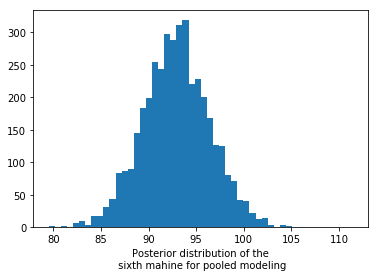

In [48]:
plt.hist(samples_pooled['mu'], 50)
plt.xlabel("Posterior distribution of the\n sixth mahine for pooled modeling")

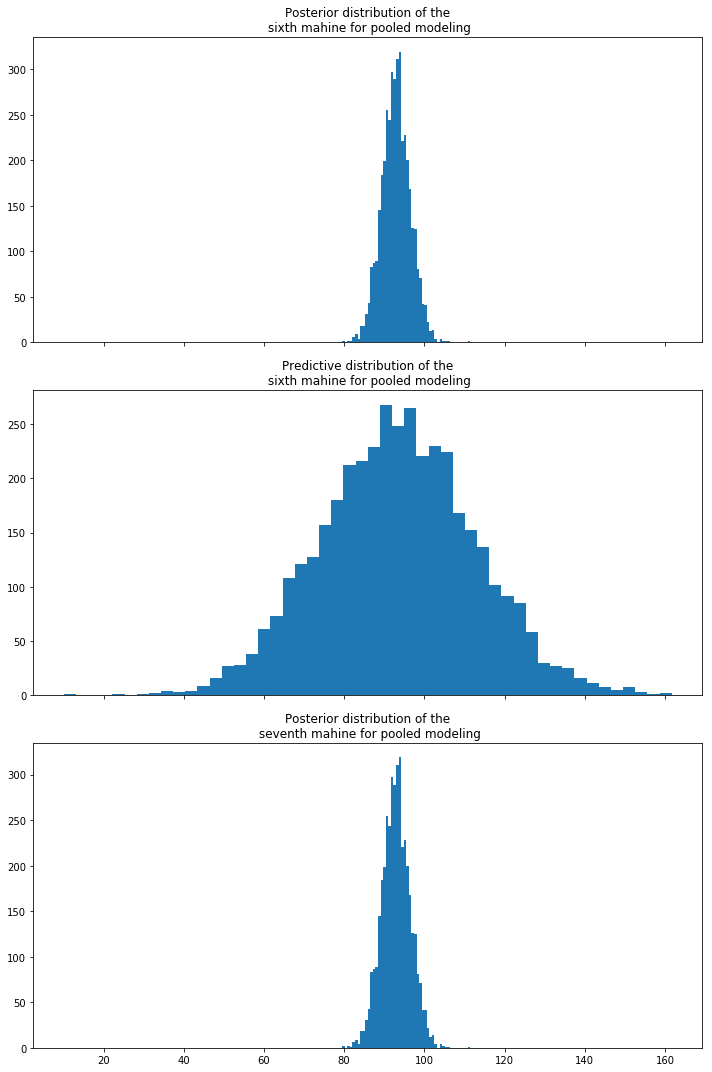

In [74]:
# create figure
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# plot the posterior density
ax = axes[0]
ax.hist(samples_pooled['mu'], 50)
ax.set_title('Posterior distribution of the\n sixth mahine for pooled modeling')

ax = axes[1]
ax.hist(samples_pooled['ypred'], 50)
ax.set_title("Predictive distribution of the\n sixth mahine for pooled modeling")

ax = axes[2]
ax.hist(samples_pooled['mu'], 50)
ax.set_title("Posterior distribution of the\n seventh mahine for pooled modeling")


fig.tight_layout()

The posterior distribution of the seventh mahine for pooled modeling is the same as any machine because they are __identical__ machines.

### (2-3) hierarchical model

Hierarchical modeling is a statistically rigorous way to make scientific inferences about a population based on many groups/observations. Humanly speaking, it's a middle ground between pooling and separate modeling. We will have the same formula as separate:

$$ y_{i,m} = \alpha_m + \beta_m \times \text{machine}_{i,m} + \epsilon_m $$

But $\alpha$ and $\beta$ come from a common group distribution:

$$\alpha_{c} \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{c} \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2)$$

So we model coefficients and predictions. That's why it's called hierarchical/multilevel modeling.

In [50]:
x = np.tile(np.arange(1, 7), d.shape[0])
y = d.ravel();y
N = len(x)
data = dict(
    N = N,
    K = 7,  # 6 machines
    x = x,  # group indicators
    y = y,   # observations
    target_machine = 5  # 6th machine
)

Our linear model:
$$ y = \beta_0 + \beta_1 \times x + e $$

$e$ is an error term sampled from $N(\mu, \sigma)$

Priors for each machine is not fixed, but rather depend on other latent variables.

In [63]:
#  Comparison of k groups with common variance and
#  hierarchical prior for the mean

data_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
    int<lower=0> target_machine;
}
parameters {
    real<lower=70, upper=110> mu0; // uniform prior mean
    real<lower=0, upper=20> sigma0; // uniform prior std
    vector[K] mu;         // group means
    real<lower=0> sigma;  // common std
}
model {
  mu ~ normal(mu0, sigma0); // population prior with unknown parameters
  y ~ normal(mu[x], sigma);
  //for (i in 1:N)
  //mu7 ~ normal(mu0, sigma0);  // Is this correct? Idk. mu7 ~ normal(mu0, sigma0) gave me low mean around 19.
}
generated quantities {
  real ypred;
  real mu7;
  real ypred7;
  vector[N] log_lik;
  ypred = normal_rng(mu[target_machine], sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[x[i]], sigma);
    
  mu7 = normal_rng(mu0,sigma0);
  ypred7 = normal_rng(mu7, sigma);

}
'''

In [64]:
sm_hierarchical =  pystan.StanModel(model_code=data_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_12d9d17d21e9ce54098156a5d9096d61 NOW.


In [72]:
fit_hierarchical = sm_hierarchical.sampling(data=data, seed=194838);

In [73]:
# Extract samples in different forms for different parameters.
# permuted : bool
#    If True, returned samples are permuted. All chains are
#    merged and warmup samples are discarded.
samples = fit_hierarchical.extract(permuted=True)

# stan_utility.check_treedepth(fit_hierarchical)
# stan_utility.check_energy(fit_hierarchical)
# stan_utility.check_div(fit_hierarchical)

`mu` is group mean. So get a column not row.

In [67]:
samples['mu'][:,5].shape,samples['ypred'].shape,samples['mu7'].shape

((4000,), (4000,), (4000,))

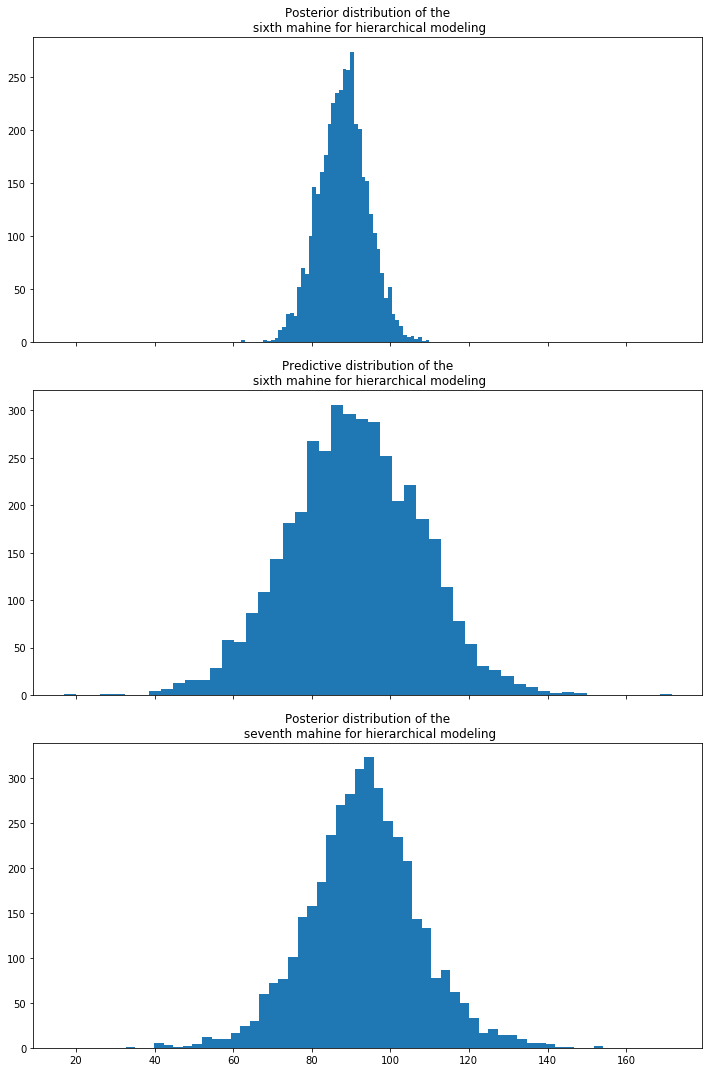

In [71]:
# create figure
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# plot the posterior density
ax = axes[0]
ax.hist(samples['mu'][:,5], 50)
ax.set_title('Posterior distribution of the\n sixth mahine for hierarchical modeling')

ax = axes[1]
ax.hist(samples['ypred'], 50)
ax.set_title("Predictive distribution of the\n sixth mahine for hierarchical modeling")

ax = axes[2]
ax.hist(samples['mu7'], 50)
ax.set_title("Posterior distribution of the\n seventh mahine for hierarchical modeling")


fig.tight_layout()

The three distributions have similar means